In [20]:
import numpy as np
import pandas
from IPython.display import Image as display
import matplotlib.pyplot as plt
import datetime
from datetime import date
import random
DOT = np.dot
PINV = np.linalg.pinv
EXP = np.exp

# Kernels

In [2]:
# Simply returns 1 is they are the same days or 0 if not
def dow_kernel(i_dow, j_dow):
    if i_dow == j_dow:
        return 1.0
    return 0

# Returns full similarity if they share the same month and day
def date_kernel(i_date, j_date):
    date_points = 0
    i = date(*map(int, i_date.split('-')))
    j = date(*map(int, j_date.split('-')))
    if i.month == j.month:
        date_points += 1.0
        if i.day == j.day:
            date_points += 1.0
    return date_points

# Return full similarity if they are the same store id
def store_kernel(i_store, j_store):
    if i_store == j_store:
        return 1.0
    return 0.0

# Assumes that 0 customers is equivalent to at least 1 customer
def customers_kernel(i_customer, j_customer):
    if i_customer == 0: i_customer = 1
    if j_customer == 0: j_customer = 1
    return min(i_customer, j_customer)/float(max(i_customer, j_customer))

# Returns full similary if the stores are both open or closed
def open_kernel(i_open, j_open):
    if i_open == j_open:
        return 1.0
    return 0.0

def promo_kernel(i_promo, j_promo):
    if i_promo == j_promo:
        return 1.0
    return 0.0

def state_holiday_kernel(i_st_holiday, j_st_holiday):
    if i_st_holiday == j_st_holiday:
        return 1.0
    return 0.0

def school_holidaty_kernel(i_sch_holiday, j_sch_holiday):
    if i_sch_holiday == j_sch_holiday:
        return 1.0
    return 0.0

# xi and xj are both data frames consisting of a single element
def kernel( xi, xj ):
    return (store_kernel( xi.Store, xj.Store ) \
        + date_kernel( xi.Date, xj.Date ) \
        * (1.0/ EXP(dow_kernel( xi.DayOfWeek, xj.DayOfWeek ) \
        * customers_kernel( xi.Customers, xj.Customers )))**2 \
        + open_kernel( xi.Open, xj.Open ) \
        + promo_kernel( xi.Promo, xj.Promo ) \
        + state_holiday_kernel( xi.StateHoliday, xj.StateHoliday ) \
        + school_holidaty_kernel( xi.SchoolHoliday, xj.SchoolHoliday ) )


In [3]:
# K(m, m) 
def K_m_m(m_landmarks):
    m = m_landmarks.shape[0]
    k = []
    for row in xrange(len(m_landmarks)):
        for col in xrange(len(m_landmarks)):
            k.append(kernel(m_landmarks.iloc[row],m_landmarks.iloc[col]))
    K = np.reshape(k, (m, m))
    return K

def K_m_n(m_landmarks, n_training):
    m = m_landmarks.shape[0]
    n = n_training.shape[0]
    k = []
    for row in xrange(len(m_landmarks)):
        for col in xrange(len(n_training)):
            k.append(kernel(m_landmarks.iloc[row],n_training.iloc[col]))
    K = np.reshape(k, (m, n))
    return K

def K_n_m(m_landmarks, n_training):
    m = m_landmarks.shape[0]
    n = n_training.shape[0]
    k = []
    for row in xrange(len(n_training)):
        for col in xrange(len(m_landmarks)):
            k.append(kernel(n_training.iloc[row],m_landmarks.iloc[col]))
    K = np.reshape(k, (n, m))
    return K

def K_t_m(m_landmarks, test_data):
    m = m_landmarks.shape[0]
    t = test_data.shape[0]
    k = []
    for row in xrange(len(test_data)):
        for col in xrange(len(m_landmarks)):
            k.append(kernel(test_data.iloc[row],m_landmarks.iloc[col]))
    K = np.reshape(k, (t, m))
    return K


In [6]:
# this is our training data
data = pandas.read_csv( 'store_train.csv' )
# test data
test_data = pandas.read_csv( 'store_train.csv' )

In [7]:
def PlotKernelMatrix(cm, n,
                          title='Kernel matrix',
                          cmap='jet'):#'PuRd'
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    

# Randomly Sampling Landmarks & Showing Kernel

In [8]:
m = 500

sample = random.sample(range(1, len(data)), m)
landmarks = data.iloc[sample]

kmm = K_m_m(landmarks)
n = np.arange(m)
PlotKernelMatrix(kmm, n)


# Choosing Landmarks more thoughtfully

In [103]:
unique_stores = random.sample(range(1, data.Store.unique().shape[0]+1), 20)

features = ["Store", "DayOfWeek", "Date", "Sales", "Customers", "Open", "Promo", "StateHoliday", "SchoolHoliday"]
landmark_list = []
counter = 1
print "store:",
for store in unique_stores:
    print counter,
    counter += 1
    for month in random.sample(range(1, 13), 6):
        for day in random.sample(range(1, 8), 5):
            two_digit_month = "{0:0=2d}".format(month)
            date_regex = '-'+ two_digit_month +'-'
            data_dow = data[( data.Date.str.contains(date_regex))][(data.Store == store)][data.DayOfWeek == day]
            values = [-1 * counter-1, \
                      day ,\
                      '2017-'+two_digit_month+'-01', \
                      data_dow.Sales.mean(), \
                      data_dow.Customers.mean(), \
                      #1,1,1,1
                      int(data_dow.Open.mean()+0.5), \
                      int(data_dow.Promo.mean()+0.5), \
                      1, \
                      1, \
                     ]
            fake_data = pandas.Series(values, index=features)
            landmark_list.append(fake_data)
print "Done Creating Landmarks!"

store: 1

/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Done Creating Landmarks!


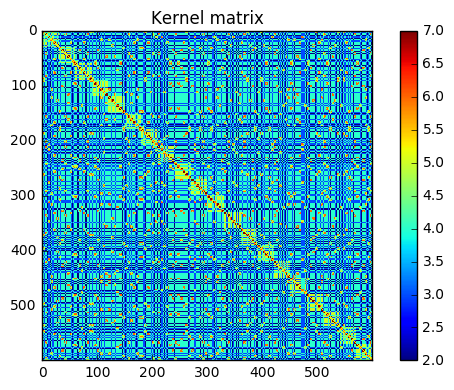

In [104]:
better_landmarks = pandas.DataFrame(landmark_list)
kmm = K_m_m(better_landmarks)
n = np.arange(m)
PlotKernelMatrix(kmm, n)

# Subset of Regressors

In [ ]:
# sample = 100

# train_sample = data.iloc[np.arange(sample)]
# test_sample =  test_data.iloc[random.sample(range(1, len(test_data)), sample)]
#y = data.Sales.reshape(sample,1)

actual = 1017209
y = data.Sales.reshape(actual, 1)
kmn =  K_m_n(landmarks, data) 
print "finished kmn"

In [ ]:
knm =  K_n_m(landmarks, data)
print "finished knm"

In [ ]:
ktm = K_t_m(landmarks, test_data)
print "finished ktm"

In [ ]:
sigma = 1.0
mu = DOT(ktm, DOT(PINV(DOT(kmn, knm) + sigma * kmm),DOT(kmn, y)))
print "finished mu"

In [49]:
print mu[1][0]

6284.31817963


## Writing predictions out to a csv

In [106]:
sfile = open( 'predict_full.csv', 'wb' )
sfile.write( '"Id","Sales"\n' )

for id in xrange(test_data.shape[0]):
    sfile.write( '%d,%.2f\n' % ( id+1, mu[id][0] ) )  # add one for one-based indexing
sfile.close()
print "Predictions Written!"

NameError: name 'mu' is not defined

# Visualizing data - The Data Scientist in me 

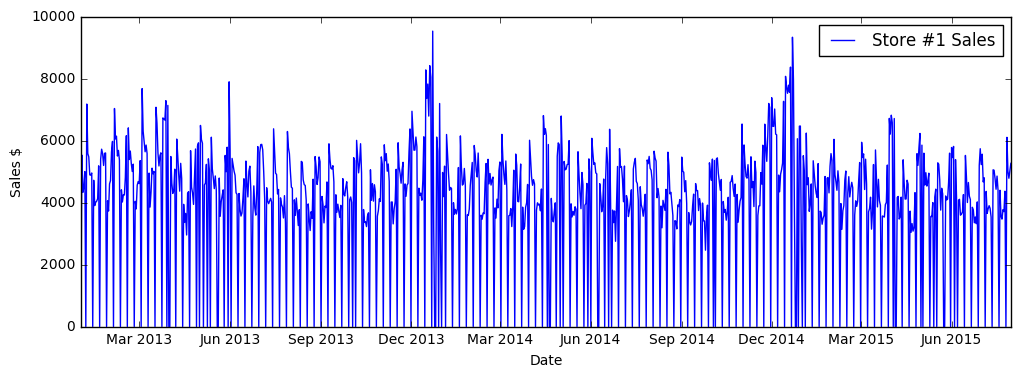

In [5]:
store = data[(data.Store == 1)]

sorted_data = store.sort_values(by="Date")
#print sorted_data[["Date", "Sales"]]

dates = sorted_data["Date"].tolist()
sales = sorted_data["Sales"].tolist()

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
# print "Current size:", fig_size
 
# Set figure width to 12 and height to 4
fig_size[0] = 12
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

plt.plot_date(dates, sales, 'b-', xdate=True)

plt.xlabel("Date")
plt.ylabel("Sales $")
plt.legend(['Store #1 Sales'], loc='upper right')
plt.show()


/Users/Iris/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


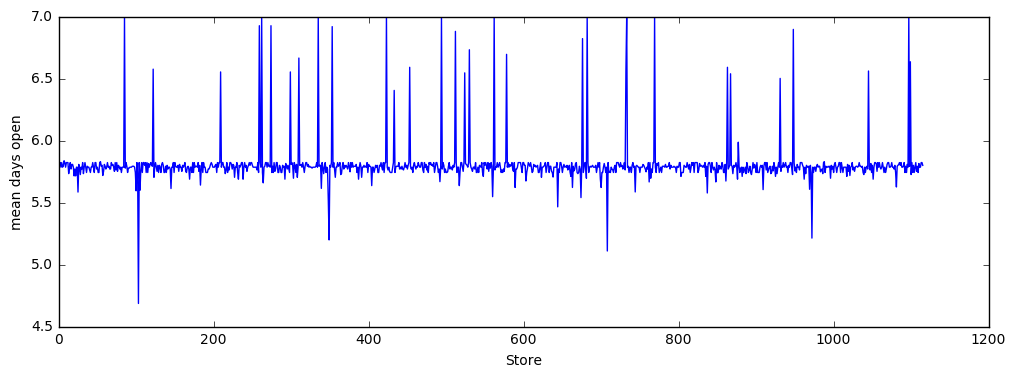

In [159]:
unique_stores = data.Store.unique()
open_mean = []
for i in unique_stores:
    days_open = data[(data.Store == i)]["DayOfWeek"].unique()
    mean_days_open_for_store = []
    for day in days_open:
        days_data = data[(data.Store == i)][data.DayOfWeek == day]
        mean_days_open = days_data["Open"].mean()
        mean_days_open_for_store.append(mean_days_open)
        
    open_mean.append(np.sum(mean_days_open_for_store))

plt.plot(unique_stores, open_mean)
plt.xlabel("Store")
plt.ylabel("mean days open")
plt.show()


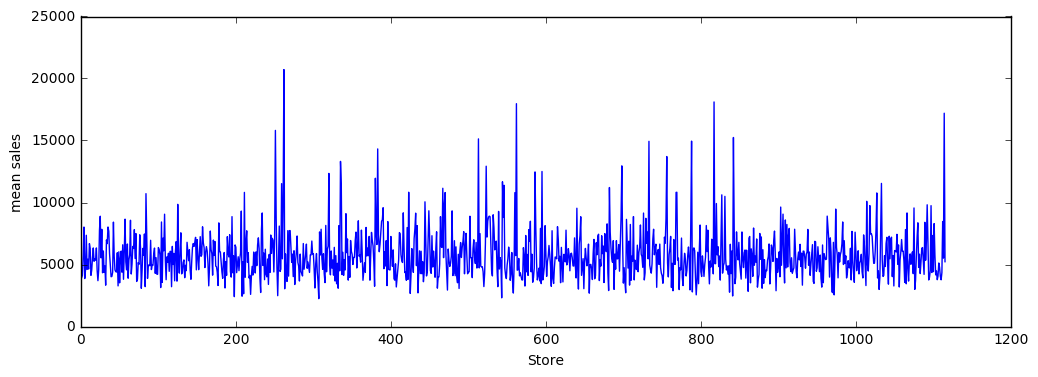

In [160]:
unique_stores = data.Store.unique()

sales_mean = []
for i in unique_stores:
    sales_mean.append(data[(data.Store == i)]["Sales"].mean())

plt.plot(unique_stores, sales_mean)
plt.xlabel("Store")
plt.ylabel("mean sales")
plt.show()

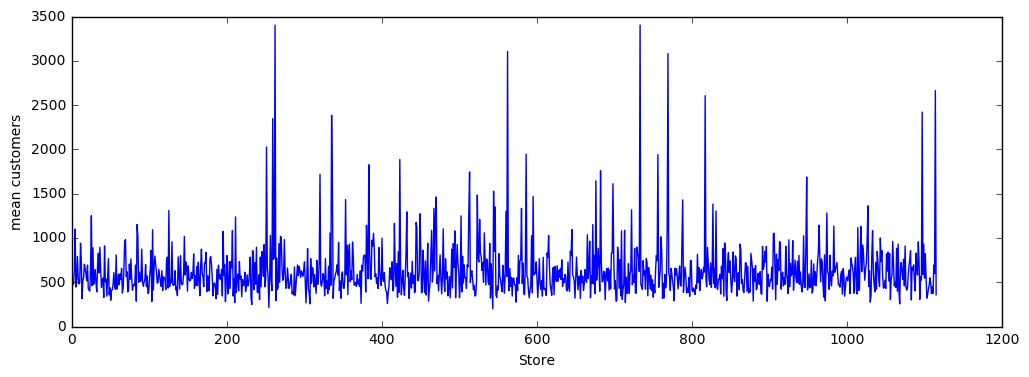

In [158]:
unique_stores = data.Store.unique()
customer_mean = []
for i in unique_stores:
    customer_mean.append(data[(data.Store == i)]["Customers"].mean())

plt.plot(unique_stores, customer_mean)
plt.xlabel("Store")
plt.ylabel("mean customers")
plt.show()